In [180]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torchvision
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [181]:
class SoftmaxClassifier:

    def __init__(self, feat_dims, output_classes, epochs, learning_rate, batch_size, regularization, momentum):

        self.feat_dims = feat_dims
        self.output_classes = output_classes
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.regularization = regularization
        self.momentum = momentum

        # create weights array/matrix size (num features x output)
        self.weights = 0.001 * np.random.rand(self.feat_dims, self.output_classes)
        self.velocity = np.zeros(self.weights.shape)

    def one_hot(self, y):
        # get a vector of labels, convert into 1 hot

        y = np.asarray(y, dtype='int32')  # convert type to int
        y = y.reshape(-1)  # convert into a list of numbers
        y_one_hot = np.zeros((len(y), self.output_classes))  # init shape of len y, and out 3 (num of classes)
        y_one_hot[np.arange(len(y)), y] = 1  # set the right indexes to 1, based on y (a list)
        return y_one_hot  # shape N by num_classes (3)

    def calc_accuracy(self, x, y):
        #  predict the class, then compare with the correct label.  return the average correct %
        preds = np.argmax(x.dot(self.weights), 1)  # get prediction
#         pred = pred.reshape((-1, 1))  # convert to column vector
        
#         correct_count = np.equal(y, preds).sum()
        avg = np.mean(np.equal(y, preds))
        
        return avg, preds   # return average over all the 1's (over the total)

    def softmax(self, x):
        # calc the softmax
        exp_x = np.exp(x - np.max(x))  # make sure it doesn't blow up by sub max

        # make sure sum along columns, and keepdims keeps the exact same dim when summing
        # ie keep cols, instead of converting to rows
        y = np.sum(exp_x, axis=1, keepdims=True)
        return exp_x / y

    def loss_and_gradient(self, x, y):
        # calc the loss and gradient.  forward prop, get softmax, calc the neg loss loss, and total loss.
        # calc dW by taking the residual, then dot with X,  + regularization
        # find average for both

        n_samples = x.shape[0]  # num of examples

        # forward prop
        f = np.dot(x, self.weights)  # mult X by W
        probs = self.softmax(f)  # pass f to softmax

        # take neg log of the highest prob. for that row
        neg_log_loss = -np.log(probs[np.arange(n_samples), np.argmax(probs, axis=1)])
        loss = np.sum(neg_log_loss)  # sum to get total loss across all samples
        # calc the regularization loss too
        reg_loss = 0.5 * self.regularization * np.sum(self.weights * self.weights)
        total_loss = (loss / n_samples) + reg_loss  # sum to get total, divide for avg

        # calc dW
        y_one_hot = self.one_hot(y)  # need one hot

        # calc derivative of loss (including regularization derivative)
        dW = x.T.dot( (probs - y_one_hot) ) + (self.regularization * self.weights) 
        dW /= n_samples  # compute average dW

        return total_loss, dW

    def train_phase(self, x_train, y_train):
        # shuffle data together, and forward prop by batch size, and add momentum

        num_train = x_train.shape[0]
        losses = []
        # Randomize the data (using sklearn shuffle)
        x_train, y_train = shuffle(x_train, y_train)

        # get the next batch (loop through number of training samples, step by batch size)
        for i in range(0, num_train, self.batch_size):

            # grab the next batch size
            x_train_batch = x_train[i:i + self.batch_size]
            y_train_batch = y_train[i:i + self.batch_size]

            # forward prop
            loss, dW = self.loss_and_gradient(x_train_batch, y_train_batch)  # calc loss and dW
            # calc velocity
            self.velocity = (self.momentum * self.velocity) + (self.learning_rate * dW)
            self.weights -= self.velocity  # update the weights
            losses.append(loss)  # save the losses

        return np.average(losses)  # return the average

    def test_phase(self, x, y_test):
        # extra, but more explicit calc of loss and gradient during testing (no back prop)

        loss, _ = self.loss_and_gradient(x, y_test)  # calc loss and dW (don't need)
        return loss
    
    def flatten(self, x):
        
        d1, d2, d3, d4 = x.shape
        # for each row, flatten the rest of the dims
        x = x.reshape((d1, -1))  
        return x
        
    def run_epochs(self, x_train, y_train, x_test, y_test):
        # start the training/valid by looping through epochs

        # store losses and accuracies here
        train_losses = []
        test_losses = []
        train_acc_arr = []
        test_acc_arr = []
        
        # need to flatten x_train features
        x_train = self.flatten(x_train)
        x_test = self.flatten(x_test)
        
#         print('before ephoch loop')
#         print('x shape in flatten', x_train.shape)

        for e in range(self.epochs): # loop through epochs

            print('Ephoch {} / {}...'.format(e + 1, self.epochs))

            # calc loss and accuracies
            train_loss = self.train_phase(x_train, y_train)
            test_loss = self.test_phase(x_test, y_test)
            train_acc, train_preds = self.calc_accuracy(x_train, y_train)
            test_acc, test_preds = self.calc_accuracy(x_test, y_test)

            # append vals to lists
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_acc_arr.append(train_acc)
            test_acc_arr.append(test_acc)

        return train_losses, test_losses, train_acc_arr, test_acc_arr, test_preds  # return all the vals

    def plot_graph(self, train_losses, test_losses, train_acc, test_acc):
        # plot graph
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train loss")
        plt.plot(test_losses, label="Test loss")
        plt.legend(loc='best')
        plt.title("Epochs vs. Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss (Cross entropy)")

        plt.subplot(1, 2, 2)
        plt.plot(train_acc, label="Train Accuracy")
        plt.plot(test_acc, label="Test Accuracy")
        # plt.legend(loc='best')
        plt.title("Epochs vs Accuracy")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()

    def make_mesh_grid(self, x, y, h=0.02):
        # make a mesh grid for the decision boundary
        
        x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
        y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
        x_x, y_y = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return x_x, y_y  # matrix of x-axis and y-axis

    def plot_contours(self, plt, x_x, y_y, **params):
        # plot contours    

        array = np.array([x_x.ravel(), y_y.ravel()])
        f = np.dot(array.T, self.weights)
        prob = self.softmax(f)
        Q = np.argmax(prob, axis=1) + 1
        Q = Q.reshape(x_x.shape)
        plt.contourf(x_x, y_y, Q, **params)  # takes in variable number of params

    def plot_decision_boundary(self, x, y):
        # plot decision boundary

        markers = ('o', '.', 'x')
        colors = ('yellow', 'grey', 'green')
        cmap = ListedColormap(colors[:len(np.unique(y))])
        x_x, y_y = self.make_mesh_grid(x, y)
        self.plot_contours(plt, x_x, y_y, cmap=plt.cm.coolwarm, alpha=0.8)
        
        # plot training points
        for idx, cl in enumerate(np.unique(y)):
            xBasedOnLabel = x[np.where(y[:,0] == cl)]
            plt.scatter(x=xBasedOnLabel[:, 0], y=xBasedOnLabel[:, 1], c=cmap(idx),
                        cmap=plt.cm.coolwarm, marker=markers[idx], label=cl)
        plt.xlim(x_x.min(), x_x.max())
        plt.ylim(y_y.min(), y_y.max())
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title("Decision Boundary - Softmax Classifier")
        plt.legend(loc='upper left')
        plt.show()

In [182]:
def loadCIFAR10():
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
#     trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
#     testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

    
    trainFeat = trainset.train_data
    trainLabels = np.asarray(trainset.train_labels)
    
    testFeat = testset.test_data
    testLabels = np.asarray(testset.test_labels)
    
    return trainLabels, trainFeat, testLabels, testFeat

In [183]:
trainLabels, trainFeat, testLabels, testFeat = loadCIFAR10()

Files already downloaded and verified
Files already downloaded and verified


In [184]:
# normalize features
trainFeat = trainFeat.astype('float32') / 255
testFeat = testFeat.astype('float32') / 255

In [185]:
# grab 3 images from each of 10 categories

classes = np.unique(trainLabels)
disp_data = []

for clas in classes:
    
    class_count = 0
    
    for i in range(len(trainLabels)):
        
        if class_count == 3:
            break  # from inner for loop
        
        if trainLabels[i] == clas:
            
            tup = (trainFeat[i], trainLabels[i])
            
            disp_data.append(tup)
            class_count += 1



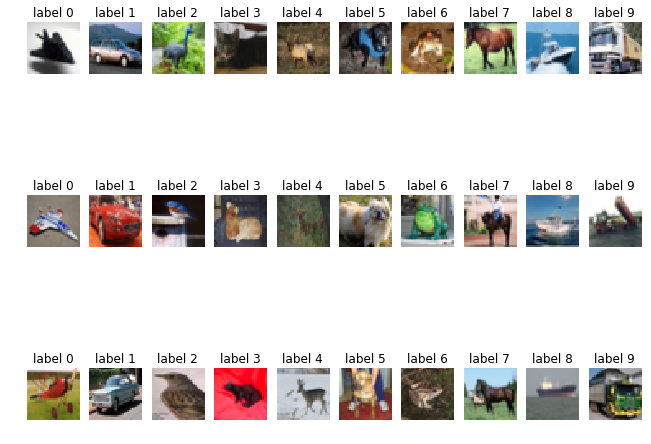

In [186]:
# plot cifar images
rows = 3
cols = 10
scale = 125

fig, axes = plt.subplots(rows, cols, figsize=(11, 9))


curr_ind = 0

for col in range(cols):
    for row in range(rows):
        
        image, label_index = disp_data[curr_ind]
        curr_ind += 1 
        axes[row][col].set_title('label {}'.format(label_index))
        axes[row][col].imshow(image)
        axes[row][col].axis('off')

plt.savefig('./cifar10')
    
    
    

In [187]:
#  ============  part 4, softmax classifier on CIFAR ==================

In [188]:
# set hyperparameters

d1, d2, d3, d4 = trainFeat.shape

feat_dims = d2*d3*d4
output_classes = 10
epochs = 100
learning_rate = 0.0001  # [0.1, 0.01, 0.001. 0.0001, 0.000001]
batch_size = 8  # try powers of 2
regularization = 0.01  # L2 weight decay, range [1, 0.1, 0.01, 0.001]
momentum = 0.10  # started with 0 to 1

In [189]:
smc = SoftmaxClassifier(feat_dims, output_classes, epochs, learning_rate, batch_size, regularization, momentum)

In [190]:
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [191]:
train_losses, test_losses, train_acc, test_acc, preds = smc.run_epochs(trainFeat, trainLabels, testFeat, testLabels)

Ephoch 1 / 100...
Ephoch 2 / 100...
Ephoch 3 / 100...
Ephoch 4 / 100...
Ephoch 5 / 100...
Ephoch 6 / 100...
Ephoch 7 / 100...
Ephoch 8 / 100...
Ephoch 9 / 100...
Ephoch 10 / 100...
Ephoch 11 / 100...
Ephoch 12 / 100...
Ephoch 13 / 100...
Ephoch 14 / 100...
Ephoch 15 / 100...
Ephoch 16 / 100...
Ephoch 17 / 100...
Ephoch 18 / 100...
Ephoch 19 / 100...
Ephoch 20 / 100...
Ephoch 21 / 100...
Ephoch 22 / 100...
Ephoch 23 / 100...
Ephoch 24 / 100...
Ephoch 25 / 100...
Ephoch 26 / 100...
Ephoch 27 / 100...
Ephoch 28 / 100...
Ephoch 29 / 100...
Ephoch 30 / 100...
Ephoch 31 / 100...
Ephoch 32 / 100...
Ephoch 33 / 100...
Ephoch 34 / 100...
Ephoch 35 / 100...
Ephoch 36 / 100...
Ephoch 37 / 100...
Ephoch 38 / 100...
Ephoch 39 / 100...
Ephoch 40 / 100...
Ephoch 41 / 100...
Ephoch 42 / 100...
Ephoch 43 / 100...
Ephoch 44 / 100...
Ephoch 45 / 100...
Ephoch 46 / 100...
Ephoch 47 / 100...
Ephoch 48 / 100...
Ephoch 49 / 100...
Ephoch 50 / 100...
Ephoch 51 / 100...
Ephoch 52 / 100...
Ephoch 53 / 100...
Ep

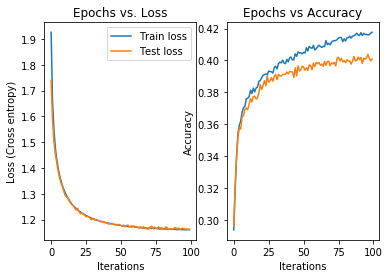

In [192]:
smc.plot_graph(train_losses, test_losses, train_acc, test_acc)

In [193]:
# find best accuracy
best_acc = np.max(test_acc)
best_acc

0.4038

In [194]:
# confusion matrix
confusion_matrix(testLabels, preds)

array([[491,  38,  48,  44,  17,  27,  23,  44, 182,  86],
       [ 77, 433,  17,  32,  21,  55,  37,  46, 100, 182],
       [119,  31, 248,  99, 119,  97, 141,  65,  55,  26],
       [ 51,  39,  89, 276,  50, 214, 107,  47,  46,  81],
       [ 71,  20, 136,  61, 290,  97, 158, 111,  30,  26],
       [ 40,  31,  88, 164,  69, 366,  84,  74,  56,  28],
       [ 13,  37,  75, 132,  94,  81, 475,  29,  24,  40],
       [ 53,  36,  58,  57,  95,  82,  53, 430,  47,  89],
       [171,  61,  10,  27,   9,  55,  13,  14, 514, 126],
       [ 93, 147,  12,  27,  15,  30,  43,  45, 103, 485]])